In [1]:
%cd ..

/home/jupyter-tim/ba-tim


In [ ]:
# Clears results
#results = {}

In [108]:
from drlqap.taskgenerators import generators, RandomWeightsTaskGenerator, RandomMatricesTaskGenerator, LinearTaskGenerator
import scipy.optimize
from drlqap.simplesolver import solve_qap_backtracking, solve_qap_maxgreedy, solve_qap_faq, solve_random
from drlqap.gurobi import solve_qap_gurobi
import numpy as np
from drlqap.qap import QAP
from drlqap.evaltools import load_checkpoints
from pathlib import Path
import random
import matplotlib.pyplot as plt

In [137]:
agents = {}
agents["dqn_medium"] = load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1'))
agents["dqn_small"] = load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1'))
agents["dqn_mini"] = load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_mini/lr5e-4_s1'))
agents["dqn_bi"] = load_checkpoints(Path('runs/dqn_bi_increasing/lr5e-4_s1'))
agents["a2c_inc"] = load_checkpoints(Path('runs/a2c_ms100x_increasing/lr8e-5_s1'))
agents["a2c_medium"] = load_checkpoints(Path('runs/a2c_ms100x_mediumrandoms/lr4e-5_s1'))
agents["a2c_small"] = load_checkpoints(Path('runs/a2c_ms100x_smallrandoms/lr4e-5_s2'))
agents["reinforce"] = load_checkpoints(Path('runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/'))
agents["dqn_tai35a"] = load_checkpoints(Path('runs/dqn_dense_ms_ec_tai35a/lr5e-4_s1/'))
agents["mcq_small"] = load_checkpoints(Path('runs/mcq_eps0_smallrandoms/lr3e-4_s2/'))

runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_0.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_1000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_2000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_3000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_4000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_5000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_6000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_7000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_8000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_9000.pth
runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1/checkpoint_end.pth
runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1/checkpoint_0.pth
runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1/checkpoint_1000.pth
runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1/checkpoint_2000.pth
runs/dqn_dense_ms_ec_eps0_smal

runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_4000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_5000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_6000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_7000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_8000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_9000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_10000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_11000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_12000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_13000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_14000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_15000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_16000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_17000.pth
runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/checkpoint_18000.pth
runs/reinforce_m

In [90]:
def evaluate(solver, problem, samples):
    if type(problem) == str:
        generator = generators[problem]
    else:
        generator = problem
    qaps = [generator.sample() for i in range(samples)]
    return evaluate_set(solver, qaps)
    
def evaluate_set(solver, problems):
    values = []
    correct = 0
    for qap in problems:
        v_solver, assignment = solver(qap)
        v = qap.compute_value(assignment)
        if not np.isclose(v, v_solver):
            print (f"solver outputs incorrect value (got {v_solver}, actual {v})")
        values.append(v)
    mean = np.mean(values)
    print(f"mean: {mean}")
    return mean

In [6]:
problems = {}
problems["small"] = [RandomWeightsTaskGenerator(8).sample() for i in range(20)]
problems["medium"] = [RandomWeightsTaskGenerator(16).sample() for i in range(20)]
problems["large"] = [RandomWeightsTaskGenerator(32).sample() for i in range(20)]
problems["64"] = [RandomWeightsTaskGenerator(64).sample() for i in range(20)]
problems["128"] = [RandomWeightsTaskGenerator(128).sample() for i in range(20)]
problems["small_rm"] = [RandomMatricesTaskGenerator(8).sample() for i in range(20)]
problems["mini_lap"] = [LinearTaskGenerator(2).sample() for i in range(100)]

In [7]:
def sequence_evaluation(agents, problems):
    return [evaluate_set(agent.solve, problems) for agent in agents]

In [8]:
def evaluate_and_store(agent_name, problem_name):
    if (agent_name, problem_name) not in results:
        results[agent_name, problem_name] = sequence_evaluation(agents[agent_name], problems[problem_name])

# Computations

## n=32

In [111]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "dqn_mini", "mcq_small"]:
    evaluate_and_store(agent_name, "large")

mean: 246.74014282226562
mean: 244.1486053466797
mean: 243.2446746826172
mean: 235.7646484375
mean: 237.2890167236328
mean: 237.70675659179688
mean: 238.0318145751953
mean: 235.0858917236328
mean: 234.32736206054688
mean: 234.5133056640625
mean: 235.15744018554688
mean: 234.7313995361328
mean: 234.2378387451172
mean: 234.55184936523438
mean: 235.7288818359375
mean: 235.5926513671875
mean: 235.5562744140625
mean: 233.8571014404297
mean: 233.4766387939453
mean: 234.3538055419922
mean: 235.3731231689453
mean: 233.7110137939453
mean: 233.3575439453125
mean: 233.82235717773438
mean: 233.6162872314453
mean: 232.3861846923828
mean: 232.64639282226562
mean: 231.34262084960938
mean: 234.87881469726562
mean: 232.98092651367188
mean: 235.60568237304688


In [112]:
for agent_name in ["a2c_inc", "a2c_medium", "reinforce", "a2c_small"]:
    evaluate_and_store(agent_name, "large")

mean: 245.4427947998047
mean: 247.37747192382812
mean: 252.8035888671875
mean: 254.77914428710938
mean: 252.647705078125
mean: 235.8096923828125
mean: 240.6184844970703
mean: 234.1861572265625
mean: 232.4375
mean: 237.2819366455078
mean: 229.75869750976562
mean: 231.45138549804688
mean: 232.3073272705078
mean: 233.169677734375
mean: 229.5201873779297
mean: 230.83389282226562
mean: 245.55288696289062
mean: 256.38677978515625
mean: 255.03878784179688
mean: 255.76187133789062
mean: 254.1217041015625
mean: 253.5881805419922
mean: 250.31790161132812
mean: 249.72067260742188
mean: 243.51602172851562
mean: 246.3058624267578
mean: 245.8684844970703
mean: 248.73422241210938
mean: 247.65512084960938
mean: 238.16793823242188
mean: 233.1778564453125
mean: 231.1934356689453
mean: 232.5105743408203
mean: 230.29959106445312
mean: 230.6079864501953
mean: 233.46090698242188
mean: 232.46212768554688
mean: 231.3464813232422
mean: 231.2198944091797
mean: 231.22659301757812
mean: 230.65487670898438
mean: 2

In [113]:
evaluate_set(solve_qap_faq, problems["large"])

mean: 210.02597045898438


210.02597

## n=16

In [114]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "dqn_mini", "dqn_tai35a", "mcq_small"]:
    evaluate_and_store(agent_name, "medium")

mean: 60.09456253051758
mean: 63.836463928222656
mean: 64.01304626464844
mean: 60.88031005859375
mean: 59.5473518371582
mean: 58.0768928527832
mean: 57.83164596557617
mean: 59.15240478515625
mean: 57.85480499267578
mean: 58.261802673339844
mean: 57.9723014831543
mean: 62.845741271972656
mean: 60.22674560546875
mean: 57.24755859375
mean: 58.10529708862305
mean: 56.7865104675293
mean: 54.5872688293457
mean: 55.87235641479492
mean: 54.77842330932617
mean: 55.0440559387207
mean: 55.9777717590332
mean: 55.4544677734375
mean: 62.08745574951172
mean: 61.36858367919922
mean: 59.2887077331543
mean: 57.18611526489258
mean: 56.96308517456055
mean: 56.75865936279297
mean: 55.203643798828125
mean: 55.879425048828125
mean: 54.881927490234375
mean: 55.298973083496094
mean: 54.57002639770508
mean: 54.896507263183594
mean: 54.30488204956055
mean: 54.8302001953125
mean: 54.421913146972656
mean: 54.38848876953125
mean: 58.6569709777832
mean: 62.905357360839844
mean: 62.8950309753418
mean: 55.808586120605

In [115]:
for agent_name in ["a2c_inc", "a2c_medium", "reinforce", "a2c_small"]:
    evaluate_and_store(agent_name, "medium")

mean: 61.873069763183594
mean: 60.9787712097168
mean: 63.78679275512695
mean: 64.86966705322266
mean: 59.38962936401367
mean: 55.92926025390625
mean: 58.035736083984375
mean: 55.49351119995117
mean: 55.20436477661133
mean: 56.2236328125
mean: 54.399269104003906
mean: 54.59333419799805
mean: 54.50960159301758
mean: 54.634605407714844
mean: 53.42951583862305
mean: 54.615882873535156
mean: 61.093589782714844
mean: 64.54523468017578
mean: 64.97101593017578
mean: 65.1332778930664
mean: 64.3512954711914
mean: 63.78337478637695
mean: 63.934669494628906
mean: 62.40876007080078
mean: 62.24346160888672
mean: 61.32006072998047
mean: 60.5723876953125
mean: 61.49851608276367
mean: 61.22528076171875
mean: 59.540626525878906
mean: 55.69446563720703
mean: 56.00593185424805
mean: 54.89235305786133
mean: 55.2392692565918
mean: 55.11958694458008
mean: 54.3287467956543
mean: 54.4852294921875
mean: 54.368507385253906
mean: 54.3330192565918
mean: 54.195465087890625
mean: 54.21699142456055
mean: 53.706127166

In [116]:
evaluate_set(solve_qap_faq, problems["medium"])

mean: 50.421730041503906


50.42173

## n=8

In [117]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "dqn_mini", "mcq_small"]:
    evaluate_and_store(agent_name, "small")

mean: 13.476003646850586
mean: 15.142595291137695
mean: 14.97508430480957
mean: 14.078828811645508
mean: 13.045808792114258
mean: 13.009193420410156
mean: 12.943338394165039
mean: 12.955785751342773
mean: 13.107035636901855
mean: 12.852948188781738
mean: 12.574394226074219
mean: 14.809930801391602
mean: 13.09052848815918
mean: 12.365636825561523
mean: 12.201443672180176
mean: 11.870131492614746
mean: 11.580653190612793
mean: 11.559934616088867
mean: 11.445871353149414
mean: 11.409143447875977
mean: 11.442638397216797
mean: 11.053874015808105
mean: 14.15179443359375
mean: 13.77891731262207
mean: 12.665990829467773
mean: 11.869750022888184
mean: 12.404887199401855
mean: 12.116978645324707
mean: 11.915689468383789
mean: 11.71831226348877
mean: 11.82774543762207
mean: 11.681009292602539
mean: 11.867008209228516
mean: 11.763518333435059
mean: 11.870786666870117
mean: 11.794642448425293
mean: 12.069402694702148
mean: 12.002047538757324
mean: 13.1266508102417
mean: 13.238534927368164
mean: 13

In [118]:
for agent_name in ["a2c_inc", "a2c_medium", "reinforce", "a2c_small"]:
    evaluate_and_store(agent_name, "small")

mean: 13.406949043273926
mean: 13.432153701782227
mean: 14.69395923614502
mean: 14.903100967407227
mean: 12.48579216003418
mean: 11.739354133605957
mean: 12.357183456420898
mean: 11.461847305297852
mean: 11.58338737487793
mean: 11.781625747680664
mean: 11.293213844299316
mean: 11.030412673950195
mean: 11.151252746582031
mean: 11.350915908813477
mean: 11.260133743286133
mean: 11.446279525756836
mean: 13.533790588378906
mean: 14.861157417297363
mean: 15.121731758117676
mean: 14.77385139465332
mean: 15.044634819030762
mean: 14.927412033081055
mean: 14.76293659210205
mean: 14.489842414855957
mean: 14.212056159973145
mean: 14.203213691711426
mean: 14.035161018371582
mean: 14.078546524047852
mean: 13.970919609069824
mean: 13.75019359588623
mean: 12.001099586486816
mean: 11.934380531311035
mean: 11.50012493133545
mean: 11.864490509033203
mean: 11.604866981506348
mean: 11.689587593078613
mean: 11.48116397857666
mean: 11.264888763427734
mean: 11.461230278015137
mean: 11.165072441101074
mean: 11

In [119]:
evaluate_set(solve_qap_faq, problems["small"])

mean: 10.886271476745605


10.886271

In [120]:
evaluate_set(solve_qap_backtracking, problems["small"])

mean: 10.335770606994629


10.335771

In [121]:
evaluate_set(solve_random, problems["small"])

mean: 13.739766120910645


13.739766

## n=2 linear only

In [122]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "dqn_mini", "a2c_inc", "a2c_medium", "reinforce", "a2c_small", "mcq_small"]:
    evaluate_and_store(agent_name, "mini_lap")

mean: 1.0143030881881714
mean: 1.0205634832382202
mean: 0.9061641693115234
mean: 0.992786705493927
mean: 0.9893808960914612
mean: 0.970136284828186
mean: 0.9387016296386719
mean: 0.9357019066810608
mean: 0.9323581457138062
mean: 0.9514298439025879
mean: 0.9384765028953552
mean: 1.0506772994995117
mean: 0.9427359700202942
mean: 0.9531546831130981
mean: 0.9270754456520081
mean: 0.8885414600372314
mean: 0.8455635905265808
mean: 0.8215010166168213
mean: 0.82975172996521
mean: 0.844954252243042
mean: 0.8715141415596008
mean: 0.9479286670684814
mean: 1.1065319776535034
mean: 0.7900670766830444
mean: 0.8034495711326599
mean: 0.7825129628181458
mean: 0.794160783290863
mean: 0.7957251667976379
mean: 0.783005952835083
mean: 0.783005952835083
mean: 0.787614643573761
mean: 0.80533766746521
mean: 0.8123933672904968
mean: 0.8627908825874329
mean: 0.9637596607208252
mean: 1.009697437286377
mean: 1.0312285423278809
mean: 1.0251731872558594
mean: 1.0103493928909302
mean: 0.783170223236084
mean: 0.78787

# n=64

In [123]:
for agent_name in ["reinforce", "a2c_medium", "a2c_small", "mcq_small"]:
    evaluate_and_store(agent_name, "64")

mean: 1003.73291015625
mean: 1004.02490234375
mean: 998.9900512695312
mean: 994.5697021484375
mean: 996.6629028320312
mean: 1002.31787109375
mean: 992.2591552734375
mean: 999.0047607421875
mean: 994.3580932617188
mean: 987.8896484375
mean: 998.8560791015625
mean: 985.2507934570312
mean: 981.0271606445312
mean: 979.1290283203125
mean: 981.9122924804688
mean: 979.2098388671875
mean: 978.7283935546875
mean: 981.8289794921875
mean: 981.6900634765625
mean: 980.6423950195312
mean: 980.2467651367188
mean: 978.9256591796875
mean: 978.4728393554688
mean: 978.9168701171875
mean: 979.2589721679688
mean: 977.8955078125
mean: 979.9313354492188
mean: 981.1300659179688
mean: 976.6550903320312
mean: 977.0310668945312
mean: 978.1510620117188
mean: 1004.3216552734375
mean: 1027.8037109375
mean: 1025.50244140625
mean: 1023.24072265625
mean: 1019.8358154296875
mean: 1021.4464721679688
mean: 1007.9647216796875
mean: 1002.7823486328125
mean: 990.7164916992188
mean: 997.2261962890625
mean: 1006.685546875
mea

# n=128

In [124]:
for agent_name in ["reinforce", "a2c_medium", "a2c_small", "mcq_small"]:
    evaluate_and_store(agent_name, "128")

mean: 4077.955810546875
mean: 4066.034423828125
mean: 4054.91455078125
mean: 4045.27099609375
mean: 4049.21484375
mean: 4052.33642578125
mean: 4032.584716796875
mean: 4067.990234375
mean: 4037.88330078125
mean: 4031.918701171875
mean: 4067.1328125
mean: 4053.310546875
mean: 4019.240966796875
mean: 4026.86669921875
mean: 4024.869140625
mean: 4024.59326171875
mean: 4020.369140625
mean: 4018.95068359375
mean: 4020.090576171875
mean: 4019.559326171875
mean: 4021.03369140625
mean: 4014.76318359375
mean: 4016.533935546875
mean: 4013.59375
mean: 4019.028076171875
mean: 4015.979248046875
mean: 4016.92041015625
mean: 4024.73681640625
mean: 4019.473388671875
mean: 4085.728515625
mean: 4125.7333984375
mean: 4136.8134765625
mean: 4106.8369140625
mean: 4089.90234375
mean: 4083.61572265625
mean: 4079.23828125
mean: 4053.15673828125
mean: 4045.865966796875
mean: 4065.05322265625
mean: 4083.673095703125
mean: 4126.24658203125
mean: 4122.2236328125
mean: 4046.555908203125
mean: 4104.5419921875
mean: 40

In [134]:
evaluate_set(solve_qap_faq, problems["128"])

mean: 3694.09375


3694.0938

# Plots

Text(0.5, 1.0, 'Performance on n=32')

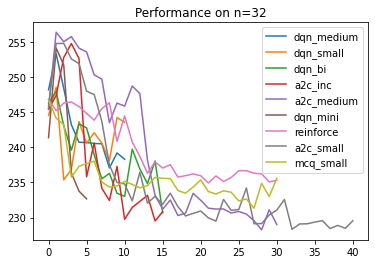

In [133]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "a2c_inc", "a2c_medium", "dqn_mini", "reinforce", "a2c_small", "mcq_small"]:
    plt.plot(results[agent_name, "large"], label=agent_name)
plt.legend()
plt.title("Performance on n=32")

Text(0.5, 1.0, 'Performance on n=16')

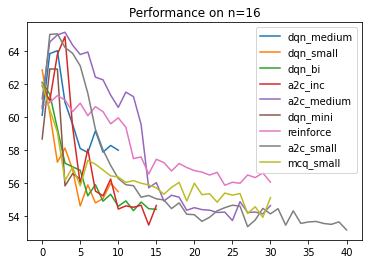

In [126]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "a2c_inc", "a2c_medium", "dqn_mini", "reinforce", "a2c_small", "mcq_small"]:
    plt.plot(results[agent_name, "medium"], label=agent_name)
plt.legend()
plt.title("Performance on n=16")

Text(0.5, 1.0, 'Performance on n=8')

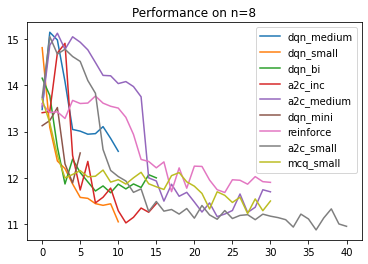

In [135]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "a2c_inc", "a2c_medium", "dqn_mini", "reinforce", "a2c_small", "mcq_small"]:
    plt.plot(results[agent_name, "small"], label=agent_name)
plt.legend()
plt.title("Performance on n=8")

Text(0.5, 1.0, 'Performance on n=2')

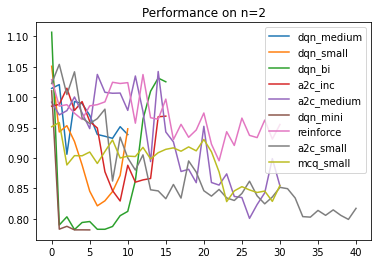

In [128]:
for agent_name in ["dqn_medium", "dqn_small", "dqn_bi", "a2c_inc", "a2c_medium", "dqn_mini", "reinforce", "a2c_small", "mcq_small"]:
    plt.plot(results[agent_name, "mini_lap"], label=agent_name)
plt.legend()
plt.title("Performance on n=2")

Text(0.5, 1.0, 'Performance on n=64')

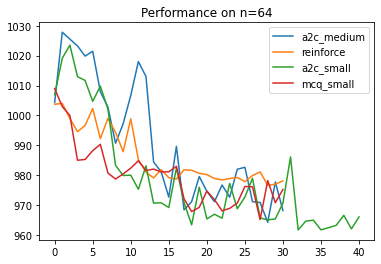

In [129]:
for agent_name in ["a2c_medium", "reinforce", "a2c_small", "mcq_small"]:
    plt.plot(results[agent_name, "64"], label=agent_name)
plt.legend()
plt.title("Performance on n=64")

Text(0.5, 1.0, 'Performance on n=128')

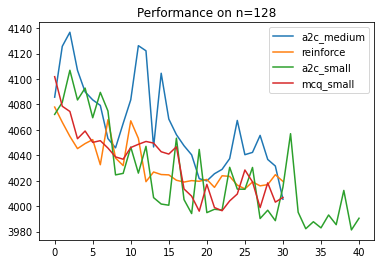

In [130]:
for agent_name in ["a2c_medium", "reinforce", "a2c_small", "mcq_small"]:
    plt.plot(results[agent_name, "128"], label=agent_name)
plt.legend()
plt.title("Performance on n=128")

In [140]:
import objgraph
objgraph.show_backrefs(random.choice(objgraph.by_type('Linear')))

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH